# Multi-Modal RAG Using SingleStore and Anthropic

- ### Create a vector store

- ### Fetch images

- ### Create embeddings

- ### Interact via the database via text

- ### Use multimodal LLM to interpret images

## Install the libraries

In [9]:
%%capture
%pip install langchain \
    anthropic \
    langchain-experimental \
    langchain-anthropic \
    pillow \
    matplotlib \
    fastembed

## Make connection to the database

In [12]:
from langchain.vectorstores import SingleStoreDB
import os
os.environ["SINGLESTOREDB_URL"] = connection_url

## Store the Anthopic API key as a secret 

In [13]:
from singlestoredb.management import get_secret

secret = get_secret('menglert_anthropic_api_key')

## Using LangChain and mentioning the embedding model and vector store

In [14]:
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

vectorstore = SingleStoreDB(
    vector_size=512,
    use_vector_index=True,
    use_full_text_search=True,
    embedding=FastEmbedEmbeddings(model_name="Qdrant/clip-ViT-B-32-text")
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/254M [00:00<?, ?B/s]

### See the table name created

In [15]:
%%sql
SHOW TABLES;

Tables_in_mallma
embeddings


### See the indexes created

In [16]:
%%sql
SHOW INDEXES FROM embeddings;

Table,Non_unique,Key_name,Seq_in_index,Column_name,Collation,Cardinality,Sub_part,Packed,Null,Index_type,Comment,Index_comment,Index_options
embeddings,0,PRIMARY,1,id,None,None,None,None,,COLUMNSTORE HASH,,,
embeddings,1,vector,1,vector,None,None,None,None,,VECTOR,,,"{""metric_type"": ""DOT_PRODUCT""}"
embeddings,1,content,1,content,utf8mb4_general_ci,None,None,None,YES,FULLTEXT,,,
embeddings,1,__SHARDKEY,1,id,None,None,None,None,,METADATA_ONLY,,,


### Download the images, puth them in a dataframe and create vector embeddings and store them in our vector database

In [17]:
import pandas as pd
from fastembed import ImageEmbedding
import requests

# Read the CSV file
df = pd.read_csv("https://raw.githubusercontent.com/morskyjezek/networked-services-labs/main/data/collection_items_data.csv")

# Filter out rows where "image_url" does not contain "Did not identify a URL."
df = df[df['image_url'] != "Did not identify a URL."]

# Sort the DataFrame by the "title" column
df = df.sort_values("title")

df = df[["title", "item_id", "image_url"]]

# Download the images and store the file paths
if not os.path.exists('images'):
    os.makedirs('images')

# Iterate over the DataFrame
for index, row in df.iterrows():
    item_id = row['item_id']
    image_url = row['image_url']

    # Download the image
    response = requests.get(image_url)

    # Save the image as item_id.jpg in the 'images' folder
    with open(f'images/{item_id}.jpg', 'wb') as file:
        file.write(response.content)

model = ImageEmbedding("Qdrant/clip-ViT-B-32-vision")

for index, row in df.iterrows():
    item_id = row['item_id']
    title = row['title']
    image_url = row['image_url']
    image_path = f'images/{item_id}.jpg'

    # Generate the embedding for the image
    embedding = list(model.embed([image_path]))[0].tolist()

    metadata = {
        "item_id": item_id,
        "image_url": image_url
    }

    vectorstore.add_images(uris=[title], embeddings=[embedding], metadatas=[metadata])

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/780 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/352M [00:00<?, ?B/s]

### The content stored/pushed to our database

In [20]:
%%sql
SELECT id, content, metadata, vector FROM embeddings LIMIT 1;

+------------------+-------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+
|        id        |               content               |                                                             metadata                                                            |                               vector                              |
+------------------+-------------------------------------+---------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------+
| 1125899906842651 | The Library of Congress, Washington | {'image_url': 'https://tile.loc.gov/storage-services/service/pnp/ppmsca/18000/18016r.jpg#h=472&w=640', 'item_id': '2008678216'} |  [-1.73540842e-02 -1.49942758e-02 -5.45526817e-02  3.58972959e-02 |
|                  |                                     |                                                                                                                                 |   -1.82729233e-02 -3.30245011e-02 -3.07879318e-02  2.54120659e-02 |
|                  |                                     |                                                                                                                                 |   -4.24720198e-02 -7.30469218e-03  5.42225204e-02 -5.76971890e-03 |
|                  |                                     |                                                                                                                                 |    1.69855654e-02 -1.49518335e-02  1.53680146e-02 -3.67278908e-03 |
|                  |                                     |                                                                                                                                 |   -6.31931648e-02 -1.65115595e-02  2.53499858e-02 -1.41979856e-02 |
|                  |                                     |                                                                                                                                 |    4.60599959e-02 -3.21033821e-02 -3.69692445e-02  4.75828871e-02 |
|                  |                                     |                                                                                                                                 |    1.16396882e-02 -3.74221313e-03 -2.19315048e-02 -1.70654990e-02 |
|                  |                                     |                                                                                                                                 |   -1.20700700e-02 -2.43786685e-02 -1.24265226e-02  3.10810655e-03 |
|                  |                                     |                                                                                                                                 |   -6.09038360e-02  1.85365248e-02  1.11045137e-01  6.32828027e-02 |
|                  |                                     |                                                                                                                                 |   -6.09080354e-03 -1.79897118e-02  4.57279338e-03  6.58619180e-02 |
|                  |                                     |                                                                                                                                 |   -3.52107957e-02 -6.57345494e-03  1.19067952e-02  1.72125176e-02 |
|                  |                                     |                                                                                                                                 |    2.70551480e-02 -8.93878937e-02 -2.03553177e-02  6.45268988e-03 |
|                  |                                     |                                                                                       

### See the pictures stored in our database

In [21]:
os.listdir('./images')

['2016632941.jpg',
 '2014650180.jpg',
 '91787443.jpg',
 '97511671.jpg',
 '98508385.jpg',
 '2017843202.jpg',
 '98508155.jpg',
 '2013646466.jpg',
 '2012630178.jpg',
 '2017880767.jpg',
 '2013646484.jpg',
 '87694100.jpg',
 '2017815837.jpg',
 '2016815290.jpg',
 '2007682033.jpg',
 '2014647618.jpg',
 '2016631919.jpg',
 '2017762724.jpg',
 '2012631625.jpg',
 '2012630017.jpg',
 '2012630164.jpg',
 '2010630352.jpg',
 '2017686535.jpg',
 '2017770391.jpg',
 '2016851550.jpg',
 '2017884872.jpg',
 '2008678216.jpg',
 '2014633407.jpg',
 '2015631425.jpg',
 '2013631511.jpg',
 '2007684172.jpg',
 '96514755.jpg',
 '2016809661.jpg',
 '2009632000.jpg',
 '2007684791.jpg']

## Let's interact with our database 

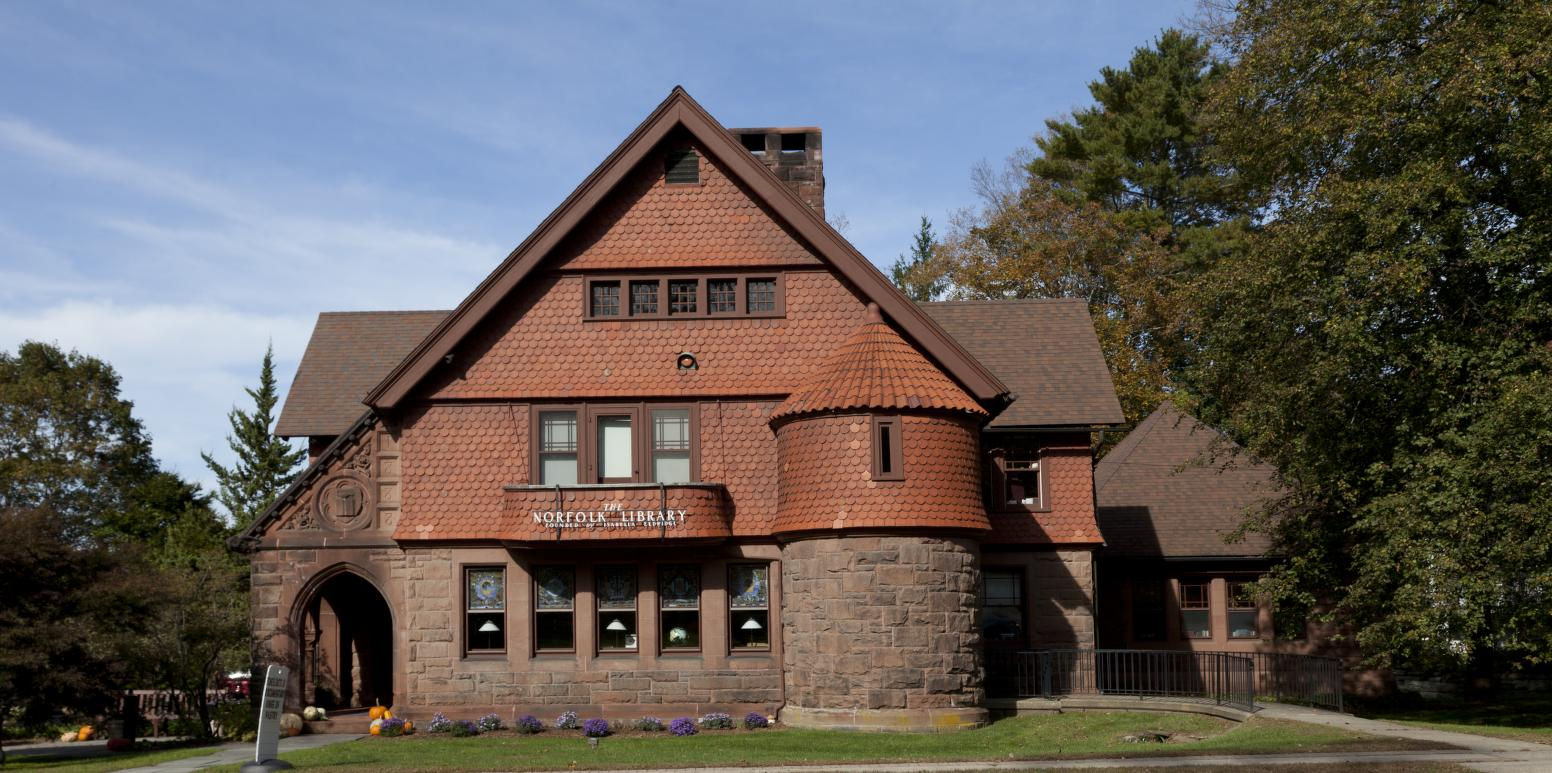

In [52]:
from IPython.display import Image

def plt_img_local(image_name):
    """Display image from a local file path"""
    # Display the image using IPython.display.Image
    display(Image(filename="./images/" + image_name))

plt_img_local('2012631625.jpg')

### Ask a query in natural language 

In [24]:
query = "Show me an image with a church"
docs = vectorstore.similarity_search_with_score(query=query, k=5)
for doc in docs:
    print(doc[0].page_content + " - Image ID: " + doc[0].metadata["item_id"] + " - Score: " + str(doc[1]))

The Cook Memorial Library, the public library of Tamworth, New Hampshire. The 1895 Queen Anne Victorian building began as a private "social library" established by Parson Samuel Hidden; the building was given to the village in memory of Charles Cook, a prominent local businessman and politician - Image ID: 2017884872 - Score: 0.27082493901252747
Carnegie Library, Cordele, Georgia - Image ID: 91787443 - Score: 0.2599845230579376
Tower of the Central Library, Los Angeles, California - Image ID: 2013631511 - Score: 0.2434794008731842
[Cossitt Library, Memphis, Tenn.] - Image ID: 2016809661 - Score: 0.24253611266613007
Handley Library, Winchester, Virginia - Image ID: 2012630178 - Score: 0.24125394225120544


In [26]:
query = "Library"

weightedSumResults = vectorstore.similarity_search_with_score(
    query,
    k=5,
    search_strategy=SingleStoreDB.SearchStrategy.WEIGHTED_SUM,
    text_weight=1,
    vector_weight=0,
)

for weightedSumResult in weightedSumResults:
    print(weightedSumResult[0].page_content + " - Image ID: " + weightedSumResult[0].metadata["item_id"] + " - Score: " + str(weightedSumResult[1]))

Handley Library, Winchester, Virginia - Image ID: 2012630178 - Score: 0.5
Carnegie Library, Cordele, Georgia - Image ID: 91787443 - Score: 0.5
[Cossitt Library, Memphis, Tenn.] - Image ID: 2016809661 - Score: 0.5
[Carnegie library, (Taunton, Mass.). Elevation] - Image ID: 96514755 - Score: 0.4375
Main entrance. Boston Public Library - Image ID: 2007682033 - Score: 0.4375


### Include the LLM and create a RAG chain

In [31]:
from IPython.display import display, Image
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage

import base64

def encode_image_base64(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def get_image_urls(docs):
    """
    Split base64-encoded images
    """
    b64_images = []
    for doc in docs:
        b64 = encode_image_base64("./images/" + doc.metadata["item_id"] + ".jpg")
        b64_images.append(b64)

    return {'images': b64_images}

def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    messages = []
    #print(data_dict)

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for img_base64 in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": f"User-provided question: {data_dict['question']}\n\n"
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]

def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatAnthropic(temperature=0, model="claude-3-haiku-20240307", max_tokens=1024, api_key=secret)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(get_image_urls),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

# Create RAG chain

retriever = vectorstore.as_retriever()

chain_multimodal_rag = multi_modal_rag_chain(retriever)

### Ask a query

In [33]:
query="Give me a picture with an ice bear."
docs = vectorstore.similarity_search_with_score(query=query, k=2)
for doc in docs:
    print(doc[0].page_content + " - Image ID: " + doc[0].metadata["item_id"] + " - Score: " + str(doc[1]))

An upright polar bear in Cincinnati, Ohio not at the zoo, since it's stuffed, or at the city's Museum Center, which owns the specimen, but at Cincinnati's main library - Image ID: 2016632941 - Score: 0.26525285840034485
The public library in Shepherdstown, West Virginia - Image ID: 2015631425 - Score: 0.17396393418312073
